# Visualize prevalence of org. science perspectives using classification predictions

@author: Jaren Haber, PhD<br>
@coauthors: Prof. Heather Haveman, UC Berkeley; Yoon Sung Hong, Wayfair<br>
@contact: Jaren.Haber@georgetown.edu<br>
@project: Computational Literature Review of Organizational Scholarship<br>
@repo: https://github.com/h2researchgroup/classification/<br>
@date: February 2021

'''
Uses predictions from classifiers trained on labeled articles (uses a perspective or not) to visualize longitudinal patterns in use of perspectives in organizational theory (cultural, relational, and demographic) for hand-labeling. Data source is full academic articles in sociology or management/org. behavior from JSTOR. 
'''

## Initialize

In [1]:
######################################################
# Import libraries
######################################################

import pandas as pd
import numpy as np
import re, csv, os
from datetime import date
from random import sample
from collections import Counter
from tqdm import tqdm
import time
from time import sleep
import random
random.seed(43)
from scipy import integrate

import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
fig = plt.gcf() # For saving better figures

import joblib
import math

import sys; sys.path.insert(0, "../preprocess/") # For loading functions from files in other directory
#from clean_text import stopwords_make, punctstr_make, unicode_make, apache_tokenize, clean_sentence_apache # for preprocessing text
from quickpickle import quickpickle_dump, quickpickle_load # custom scripts for quick saving & loading to pickle format
from text_to_file import write_textlist, read_text # custom scripts for reading and writing text lists to .txt files

In [7]:
######################################################
# Define filepaths
######################################################

thisday = date.today().strftime("%m%d%y")

cwd = os.getcwd()
root = str.replace(cwd, 'classification/modeling', '')

# Directory for prepared data and trained models: save files here
data_fp = root + 'classification/data/' # public data files (no raw JSTOR data)
model_fp = root + 'classification/models/'
prepped_fp = root + 'models_storage/preprocessed_texts/'
storage_fp = root + 'models_storage/'# private repo for output files (contains JSTOR data)

# Current article lists
article_list_fp = data_fp + 'filtered_length_index.csv' # Filtered index of research articles
article_paths_fp = data_fp + 'filtered_length_article_paths.csv' # List of article file paths
article_names_fp = data_fp + 'filtered_length_article_names.xlsx' # Filtered list of article names and general data, sorted by journal then article name

# Per-article metadata with year and URL info
meta_fp = storage_fp + 'metadata/metadata_combined_030921.h5' 

# Articles with Web of Science API matches to confirm publication year
wos_fp = data_fp + 'merged_wos_030421.csv'

# Path to predictions for all perspectives
predicted_fp = model_fp + 'predictions_MLP_65365_022621.pkl' # 'predictions_RF_65365_121620.pkl'

## Load & merge data

In [24]:
# Read in metadata file
df_meta = pd.read_hdf(meta_fp)
df_meta.reset_index(drop=False, inplace=True) # extract file name from index

# For merging purposes, get ID alone from file name, e.g. 'journal-article-10.2307_2065002' -> '10.2307_2065002'
df_meta['edited_filename'] = df_meta['file_name'].apply(lambda x: x[16:]) 
df_meta = df_meta[["edited_filename", "article_name", "jstor_url", "abstract", "journal_title", "given_names", "primary_subject", "year", "type"]] # keep only relevant columns

print("Rows, cols in data:", df_meta.shape)
df_meta.head()

Rows, cols in data: (238501, 9)


,edited_filename,article_name,jstor_url,abstract,journal_title,given_names,primary_subject,year,type
0,10.2307_4167860,Cross-Dialectal Variation in Arabic: Competing...,https://www.jstor.org/stable/4167860,Most researchers of Arabic sociolinguistics as...,Language in Society,None,Other,1979,research-article
1,10.2307_2578336,None,https://www.jstor.org/stable/2578336,None,Social Forces,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...",Sociology,1983,book-review
2,10.2307_2654760,None,https://www.jstor.org/stable/2654760,None,Contemporary Sociology,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...",Sociology,1998,book-review
3,10.2307_43242281,editor's note: A KNIGHT'S TALE,https://www.jstor.org/stable/43242281,None,Corporate Knights,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...",Other,2005,misc
4,10.2307_42862018,None,https://www.jstor.org/stable/42862018,None,Social Science Quarterly,"[Sidney, Hyman P., Riv-Ellen, Stephen, Thomas,...",Sociology,1985,book-review


In [25]:
# Read in predictions file
df_pred = quickpickle_load(predicted_fp)
df_pred.head()

,file_name,prediction_cult,prediction_cult_prob_yes,prediction_cult_prob_no,prediction_relt,prediction_relt_prob_yes,prediction_relt_prob_no,prediction_demog,prediction_demog_prob_yes,prediction_demog_prob_no,prediction_orgs,prediction_orgs_prob_yes,prediction_orgs_prob_no
0,/vol_b/data/jstor_data/ocr/journal-article-10....,yes,0.834180,1.658200e-01,yes,9.999984e-01,0.000002,no,6.852263e-09,1.0,yes,1.0,0.0
1,/vol_b/data/jstor_data/ocr/journal-article-10....,yes,0.999999,7.152557e-07,yes,9.410939e-01,0.058906,yes,1.000000e+00,0.0,yes,1.0,0.0
2,/vol_b/data/jstor_data/ocr/journal-article-10....,yes,0.858206,1.417942e-01,yes,1.000000e+00,0.000000,no,1.322212e-08,1.0,yes,1.0,0.0
3,/vol_b/data/jstor_data/ocr/journal-article-10....,yes,1.000000,2.384186e-07,no,5.699001e-09,1.000000,no,2.465694e-08,1.0,yes,1.0,0.0
4,/vol_b/data/jstor_data/ocr/journal-article-10....,yes,0.999998,1.788139e-06,yes,9.999682e-01,0.000032,no,3.142881e-07,1.0,yes,1.0,0.0


In [26]:
# Read in filtered index
df = pd.read_csv(article_list_fp, low_memory=False, header=None, names=["file_name"])
df['edited_filename'] = df['file_name'].apply(lambda x: x[16:]) # New col with only article ID

# Read predictions using latest models
df_pred = quickpickle_load(predicted_fp)

# For consistency across data sources, rename absolute file path to 'file_path' and create shorter 'file_name'
df_pred['file_path'] = df_pred['file_name'] # rename for consistency across files
df_pred['file_name'] = df_pred['file_name'].str.replace(
    '/vol_b/data/jstor_data/ocr/', '').str.replace('.txt', '') # remove folders + file suffix

# Merge meta data, predictions into articles list DF
df = pd.merge(df, df_meta, how='left', on='edited_filename') # meta data
df = pd.merge(df, df_pred, how='right', on='file_name') # predictions

print("Rows, cols in data so far:", df.shape)

df.head()

Rows, cols in data so far: (65365, 23)


,file_name,edited_filename,article_name,jstor_url,abstract,journal_title,given_names,primary_subject,year,type,...,prediction_relt,prediction_relt_prob_yes,prediction_relt_prob_no,prediction_demog,prediction_demog_prob_yes,prediction_demog_prob_no,prediction_orgs,prediction_orgs_prob_yes,prediction_orgs_prob_no,file_path
0,journal-article-10.2307_2065002,10.2307_2065002,Toward More Cumulative Inquiry,https://www.jstor.org/stable/2065002,None,Contemporary Sociology,"[Ariela, ARTHUR J., John A., Marilyn, Janemari...",Sociology,1978,research-article,...,no,0.068754,0.931246,no,0.033144,0.966856,no,0.002368,0.997632,/vol_b/data/jstor_data/ocr/journal-article-10....
1,journal-article-10.2307_3380821,10.2307_3380821,An Analysis of an Incentive Sick Leave Policy ...,https://www.jstor.org/stable/3380821,Local health departments are under tremendous ...,Public Productivity & Management Review,"[Werner, Werner, Konrad, Rudi, Paul, Jean, Rob...",Management & Organizational Behavior,1986,research-article,...,no,0.099212,0.900788,yes,0.938169,0.061831,yes,0.893345,0.106655,/vol_b/data/jstor_data/ocr/journal-article-10....
2,journal-article-10.2307_2095822,10.2307_2095822,Local Friendship Ties and Community Attachment...,https://www.jstor.org/stable/2095822,This study presents a multilevel empirical tes...,American Sociological Review,"[Alice O., Peter, W. Erwin, Bert, Robert W., C...",Sociology,1983,research-article,...,yes,0.872496,0.127504,no,0.296735,0.703265,yes,0.521677,0.478323,/vol_b/data/jstor_data/ocr/journal-article-10....
3,journal-article-10.2307_40836133,10.2307_40836133,Knowledge Transfer within the Multinational Fi...,https://www.jstor.org/stable/40836133,This paper examines the process of knowledge t...,MIR: Management International Review,"[Ariela, ARTHUR J., John A., Marilyn, Janemari...",Management & Organizational Behavior,2005,research-article,...,no,0.024153,0.975847,no,0.025947,0.974053,no,0.000218,0.999782,/vol_b/data/jstor_data/ocr/journal-article-10....
4,journal-article-10.2307_2579666,10.2307_2579666,Dynamics of Labor Market Segmentation in Polan...,https://www.jstor.org/stable/2579666,Research in the early 1980s showed that indust...,Social Forces,"[Ariela, ARTHUR J., John A., Marilyn, Janemari...",Sociology,1990,research-article,...,no,0.471403,0.528597,no,0.001887,0.998113,no,0.007546,0.992454,/vol_b/data/jstor_data/ocr/journal-article-10....


In [27]:
# Read in Web of Science API output
wos_df = pd.read_csv(wos_fp, low_memory = False)
wos_df = wos_df[['edited_filename', 'year_wos', 'article_name_wos', 'similarity_wos_title']]
wos_df['year_wos'] = wos_df[wos_df['year_wos'].notnull()]['year_wos'].astype('int32')
df.rename(columns={'year':'year_jstor'}, inplace = True)

# Remove WOS matches if titles aren't very similar = have low fuzz.ratio score 
wos_df = wos_df[wos_df['similarity_wos_title'] > 65.0]
print(f"# articles with pub year verified by API: {str(wos_df.shape[0])}")

# Merge WOS with main DF, keep only articles with verified publication year
df = pd.merge(df, wos_df, how='left', on='edited_filename')
df = df[df['year_wos'].notnull()].reset_index(drop=True) # filter
              
# Show all columns in resulting DF
print("All columns:\n", list(df))
print()

print("Rows, cols in final data:", df.shape)

df.head()

# articles with pub year verified by API: 36981
All columns:
 ['file_name', 'edited_filename', 'article_name', 'jstor_url', 'abstract', 'journal_title', 'given_names', 'primary_subject', 'year_jstor', 'type', 'prediction_cult', 'prediction_cult_prob_yes', 'prediction_cult_prob_no', 'prediction_relt', 'prediction_relt_prob_yes', 'prediction_relt_prob_no', 'prediction_demog', 'prediction_demog_prob_yes', 'prediction_demog_prob_no', 'prediction_orgs', 'prediction_orgs_prob_yes', 'prediction_orgs_prob_no', 'file_path', 'year_wos', 'article_name_wos', 'similarity_wos_title']

Rows, cols in final data: (65365, 26)


,file_name,edited_filename,article_name,jstor_url,abstract,journal_title,given_names,primary_subject,year_jstor,type,...,prediction_demog,prediction_demog_prob_yes,prediction_demog_prob_no,prediction_orgs,prediction_orgs_prob_yes,prediction_orgs_prob_no,file_path,year_wos,article_name_wos,similarity_wos_title
0,journal-article-10.2307_2065002,10.2307_2065002,Toward More Cumulative Inquiry,https://www.jstor.org/stable/2065002,None,Contemporary Sociology,"[Ariela, ARTHUR J., John A., Marilyn, Janemari...",Sociology,1978,research-article,...,no,3.314433e-02,0.966856,no,0.002368,0.997632,/vol_b/data/jstor_data/ocr/journal-article-10....,NaN,NaN,NaN
1,journal-article-10.2307_3380821,10.2307_3380821,An Analysis of an Incentive Sick Leave Policy ...,https://www.jstor.org/stable/3380821,Local health departments are under tremendous ...,Public Productivity & Management Review,"[Werner, Werner, Konrad, Rudi, Paul, Jean, Rob...",Management & Organizational Behavior,1986,research-article,...,yes,9.381695e-01,0.061831,yes,0.893345,0.106655,/vol_b/data/jstor_data/ocr/journal-article-10....,NaN,NaN,NaN
2,journal-article-10.2307_2095822,10.2307_2095822,Local Friendship Ties and Community Attachment...,https://www.jstor.org/stable/2095822,This study presents a multilevel empirical tes...,American Sociological Review,"[Alice O., Peter, W. Erwin, Bert, Robert W., C...",Sociology,1983,research-article,...,no,2.967349e-01,0.703265,yes,0.521677,0.478323,/vol_b/data/jstor_data/ocr/journal-article-10....,1988.0,LOCAL FRIENDSHIP TIES AND COMMUNITY ATTACHMENT...,98.0
3,journal-article-10.2307_40836133,10.2307_40836133,Knowledge Transfer within the Multinational Fi...,https://www.jstor.org/stable/40836133,This paper examines the process of knowledge t...,MIR: Management International Review,"[Ariela, ARTHUR J., John A., Marilyn, Janemari...",Management & Organizational Behavior,2005,research-article,...,no,2.594706e-02,0.974053,no,0.000218,0.999782,/vol_b/data/jstor_data/ocr/journal-article-10....,NaN,NaN,NaN
4,journal-article-10.2307_2579666,10.2307_2579666,Dynamics of Labor Market Segmentation in Polan...,https://www.jstor.org/stable/2579666,Research in the early 1980s showed that indust...,Social Forces,"[Ariela, ARTHUR J., John A., Marilyn, Janemari...",Sociology,1990,research-article,...,no,1.886994e-03,0.998113,no,0.007546,0.992454,/vol_b/data/jstor_data/ocr/journal-article-10....,1990.0,DYNAMICS OF LABOR-MARKET SEGMENTATION IN POLAN...,98.0
5,journal-article-10.2307_2137036,10.2307_2137036,Stressful Life Events and Depressive Symptoms:...,https://www.jstor.org/stable/2137036,We present evidence indicating that life event...,Journal of Health and Social Behavior,"[Kelly, Sanjay K., C., V., M., R., W., R.E., C...",Sociology,1977,research-article,...,yes,7.479443e-01,0.252056,no,0.000743,0.999257,/vol_b/data/jstor_data/ocr/journal-article-10....,1988.0,STRESSFUL LIFE EVENTS AND DEPRESSIVE SYMPTOMS ...,99.0
6,journal-article-10.2307_27747507,10.2307_27747507,U.S. Capitalism: A Tarnished Model?,https://www.jstor.org/stable/27747507,The apparent success of the U.S. model of capi...,Academy of Management Perspectives,"[Randy, Cecilia, Pierre, Anne, Gurumurthy K., ...",Management & Organizational Behavior,2009,research-article,...,no,4.059918e-08,1.000000,no,0.000269,0.999731,/vol_b/data/jstor_data/ocr/journal-article-10....,NaN,NaN,NaN
7,journal-article-10.2307_41274741,10.2307_41274741,XIth Polish Sociological Congress,https://www.jstor.org/stable/41274741,None,Polish Sociological Review,None,Sociology,2000,research-article,...,yes,9.964151e-01,0.003585,no,0.184618,0.815382,/vol_b/data/jstor_data/ocr/journal-article-10....,NaN,NaN,NaN
8,journal-article-10.2307_24708246,10.2307_24708246,"More women, lower pay? Occupational sex compos...",https://www.jstor.org/stable/24708246,Research consistently shows that the share of ...,Acta Sociologica,"[Werner, Werner, Konrad, Rudi, Paul, Jean, Rob...",Sociology,2013,research-article,...,yes,9.677171e-01,0.032283,

### Convert No/Yes to [0,1]

In [28]:
def no_yes_convert(convert_df, column_name, has_unsure = False):
    '''
    args
        convert_df: df containing column to convert
        column_name: column to convert from 'yes','no','unsure' to float. Scoring scheme:
            no: 0
            unsure: 0.5
            yes: 1
        has_unsure: boolean, indicates whether convert_df has 'unsure' in column_name
    '''
    
    # Already converted to float
    if convert_df[column_name].dtype == 'float64':
        return convert_df
    
    new_df = convert_df.loc[:, convert_df.columns != column_name]
    
    for num in range(0,len(new_df)):
        row_index = new_df.index[num]
        
        if convert_df.loc[num,column_name] == 'no':
            new_df.loc[row_index,column_name] = 0.0
            
        elif convert_df.loc[num,column_name] == 'yes':
            new_df.loc[row_index,column_name] = 1.0
            
        elif has_unsure == True and convert_df.loc[num,column_name] == 'unsure':
            new_df.loc[row_index,column_name] = 0.5
            
    return new_df

try:
    df = no_yes_convert(df,'prediction_cult')
    df = no_yes_convert(df,'prediction_relt')
    df = no_yes_convert(df,'prediction_demog')
except KeyError as e:
    print(f'Error: {e}')

### Filter sociology -> organizational sociology

In [54]:
minority_threshold_orgs = 0.5
df_orgsoc = df[df['primary_subject']=='Sociology'][df['prediction_orgs_prob_yes'] > minority_threshold_orgs].reset_index(drop=True)

print(df_orgsoc.shape)
df_orgsoc.head()

(4176, 28)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,file_name,edited_filename,article_name,jstor_url,abstract,journal_title,given_names,primary_subject,year_jstor,type,...,prediction_orgs_prob_no,file_path,year_wos,article_name_wos,similarity_wos_title,prediction_cult,prediction_relt,prediction_demog,year_int,year_int_temp
0,journal-article-10.2307_2095822,10.2307_2095822,Local Friendship Ties and Community Attachment...,https://www.jstor.org/stable/2095822,This study presents a multilevel empirical tes...,American Sociological Review,"[Alice O., Peter, W. Erwin, Bert, Robert W., C...",Sociology,1983,research-article,...,0.478323,/vol_b/data/jstor_data/ocr/journal-article-10....,1988.0,LOCAL FRIENDSHIP TIES AND COMMUNITY ATTACHMENT...,98.0,1.0,1.0,0.0,1988,1988
1,journal-article-10.2307_24048141,10.2307_24048141,Capitalizing social networks: Sri Lankan migra...,https://www.jstor.org/stable/24048141,Social capital is usually seen as a fixed asse...,Ethnography,"[Noëlle, MICHAEL, Wolf F., Eberhard K., Peter,...",Sociology,2011,research-article,...,0.012570,/vol_b/data/jstor_data/ocr/journal-article-10....,2011.0,Capitalizing social networks: Sri Lankan migra...,100.0,0.0,0.0,1.0,2011,2011
2,journal-article-10.2307_583974,10.2307_583974,Developing Respite Care: A Support Service for...,https://www.jstor.org/stable/583974,Respite care is identified as a temporary reli...,Family Relations,"[Werner, Werner, Konrad, Rudi, Paul, Jean, Rob...",Sociology,1978,research-article,...,0.357715,/vol_b/data/jstor_data/ocr/journal-article-10....,1983.0,DEVELOPING RESPITE CARE - A SUPPORT SERVICE FO...,98.0,0.0,0.0,1.0,1983,1983
3,journal-article-10.2307_42956069,10.2307_42956069,Organized Interests and Political Extortion: A...,https://www.jstor.org/stable/42956069,Objectives. Although the Fetcher Bill Hypothes...,Social Science Quarterly,"[Loren C., Jeffrey, Stephen, Gerrie ter, Mathi...",Sociology,2005,research-article,...,0.046945,/vol_b/data/jstor_data/ocr/journal-article-10....,2005.0,Organized interests and political extortion: A...,100.0,0.0,1.0,0.0,2005,2005
4,journal-article-10.2307_3710716,10.2307_3710716,Christianizing the Urban Empire: An Analysis B...,https://www.jstor.org/stable/3710716,Seven ordinal variables were created for the 2...,Sociological Analysis,"[Jean, Stanley L., Robert E., Ussama, Leonard,...",Sociology,1985,research-article,...,0.477479,/vol_b/data/jstor_data/ocr/journal-article-10....,1991.0,CHRISTIANIZING THE URBAN EMPIRE - AN ANALYSIS ...,98.0,0.0,0.0,0.0,1991,1991


### Get minority class cases

In [55]:
# set thresholds for minority cases for each myth

minority_threshold_cult = 0.5 #calculate_threshold(capture_num, df['prediction_cult_prob_yes'])
minority_threshold_relt = 0.5 #calculate_threshold(capture_num, df['prediction_relt_prob_yes'])
minority_threshold_demog = 0.5 #calculate_threshold(capture_num, df['prediction_demog_prob_yes'])

# filter using threshold: select articles with prob of being in minority class
df_cult_mgt_minority = df[df['primary_subject']=='Management & Organizational Behavior'][df['prediction_cult_prob_yes'] > minority_threshold_cult]
df_relt_mgt_minority = df[df['primary_subject']=='Management & Organizational Behavior'][df['prediction_relt_prob_yes'] > minority_threshold_relt]
df_demog_mgt_minority = df[df['primary_subject']=='Management & Organizational Behavior'][df['prediction_demog_prob_yes'] > minority_threshold_demog]

# filter using threshold: select articles with prob of being in minority class
df_cult_soc_minority = df_orgsoc[df_orgsoc['prediction_cult_prob_yes'] > minority_threshold_cult]
df_relt_soc_minority = df_orgsoc[df_orgsoc['prediction_relt_prob_yes'] > minority_threshold_relt]
df_demog_soc_minority = df_orgsoc[df_orgsoc['prediction_demog_prob_yes'] > minority_threshold_demog]

print('Number of likely cultural mgt articles above prob. threshold of {}: {}'.
      format(str(minority_threshold_cult), 
      str(len(df_cult_mgt_minority))))
print('Number of likely relational mgt articles above prob. threshold of {}: {}'.
      format(str(minority_threshold_relt), 
      str(len(df_relt_mgt_minority))))
print('Number of likely demographic mgt articles above prob. threshold of {}: {}'.
      format(str(minority_threshold_demog), 
      str(len(df_demog_mgt_minority))))
print()
print('Number of likely cultural soc articles (likely about orgs) above prob. threshold of {}: {}'.
      format(str(minority_threshold_cult), 
      str(len(df_cult_soc_minority))))
print('Number of likely relational soc articles (likely about orgs) above prob. threshold of {}: {}'.
      format(str(minority_threshold_relt), 
      str(len(df_relt_soc_minority))))
print('Number of likely demographic soc articles (likely about orgs) above prob. threshold of {}: {}'.
      format(str(minority_threshold_demog), 
      str(len(df_demog_soc_minority))))

Number of likely cultural mgt articles above prob. threshold of 0.5: 783
Number of likely relational mgt articles above prob. threshold of 0.5: 2115
Number of likely demographic mgt articles above prob. threshold of 0.5: 2937

Number of likely cultural soc articles (likely about orgs) above prob. threshold of 0.5: 1242
Number of likely relational soc articles (likely about orgs) above prob. threshold of 0.5: 2040
Number of likely demographic soc articles (likely about orgs) above prob. threshold of 0.5: 1855


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


### Get majority class cases

In [56]:
# set thresholds for majority cases for each myth

majority_threshold_cult = 0.5 #calculate_threshold(capture_num, df['prediction_cult_prob_yes'])
majority_threshold_relt = 0.5 #calculate_threshold(capture_num, df['prediction_relt_prob_yes'])
majority_threshold_demog = 0.5 #calculate_threshold(capture_num, df['prediction_demog_prob_yes'])

# filter using threshold: select articles with prob of being in minority class
df_cult_mgt_majority = df[df['primary_subject']=='Management & Organizational Behavior'][df['prediction_cult_prob_yes'] < majority_threshold_cult]
df_relt_mgt_majority = df[df['primary_subject']=='Management & Organizational Behavior'][df['prediction_relt_prob_yes'] < majority_threshold_relt]
df_demog_mgt_majority = df[df['primary_subject']=='Management & Organizational Behavior'][df['prediction_demog_prob_yes'] < majority_threshold_demog]

# filter using threshold: select articles with prob of being in minority class
df_cult_soc_majority = df_orgsoc[df_orgsoc['prediction_cult_prob_yes'] < majority_threshold_cult]
df_relt_soc_majority = df_orgsoc[df_orgsoc['prediction_relt_prob_yes'] < majority_threshold_relt]
df_demog_soc_majority = df_orgsoc[df_orgsoc['prediction_demog_prob_yes'] < majority_threshold_demog]

print('Number of likely not-cultural mgt articles below prob. threshold of {}: {}'.
      format(str(majority_threshold_cult), 
      str(len(df_cult_mgt_majority))))
print('Number of likely not-relational mgt articles below prob. threshold of {}: {}'.
      format(str(majority_threshold_relt), 
      str(len(df_relt_mgt_majority))))
print('Number of likely not-demographic mgt articles below prob. threshold of {}: {}'.
      format(str(majority_threshold_demog), 
      str(len(df_demog_mgt_majority))))
print()
print('Number of likely not-cultural soc articles (likely about orgs) below prob. threshold of {}: {}'.
      format(str(majority_threshold_cult), 
      str(len(df_cult_soc_majority))))
print('Number of likely not-relational soc articles (likely about orgs) below prob. threshold of {}: {}'.
      format(str(majority_threshold_relt), 
      str(len(df_relt_soc_majority))))
print('Number of likely not-demographic soc articles (likely about orgs) below prob. threshold of {}: {}'.
      format(str(majority_threshold_demog), 
      str(len(df_demog_soc_majority))))

Number of likely not-cultural mgt articles below prob. threshold of 0.5: 9236
Number of likely not-relational mgt articles below prob. threshold of 0.5: 7904
Number of likely not-demographic mgt articles below prob. threshold of 0.5: 7082

Number of likely not-cultural soc articles (likely about orgs) below prob. threshold of 0.5: 2934
Number of likely not-relational soc articles (likely about orgs) below prob. threshold of 0.5: 2136
Number of likely not-demographic soc articles (likely about orgs) below prob. threshold of 0.5: 2321


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


## Visualize distributions

### Simple line plots of minority cases

Text(0, 0.5, 'count')

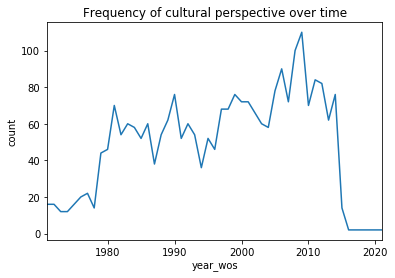

In [57]:
cult_yes_df = pd.concat([df_cult_soc_minority[['edited_filename','year_wos']], df_cult_soc_minority[['edited_filename','year_wos']]])
cult_plot = cult_yes_df[cult_yes_df['year_wos'].notnull()].groupby('year_wos').size()\
        .plot(kind='line',title='Frequency of cultural perspective over time')
cult_plot.set_ylabel('count')

Text(0, 0.5, 'count')

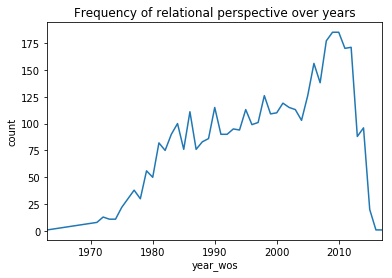

In [58]:
relt_yes_df = pd.concat([df_relt_soc_minority[['edited_filename','year_wos']], df_relt_mgt_minority[['edited_filename','year_wos']]])
relt_plot = relt_yes_df[relt_yes_df['year_wos'].notnull()].groupby('year_wos').size()\
        .plot(kind='line',title='Frequency of relational perspective over years')
relt_plot.set_ylabel('count')

Text(0, 0.5, 'count')

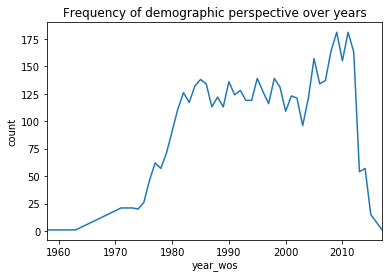

In [59]:
demog_yes_df = pd.concat([df_demog_soc_minority[['edited_filename','year_wos']], df_demog_mgt_minority[['edited_filename','year_wos']]])
demog_plot = demog_yes_df[demog_yes_df['year_wos'].notnull()].groupby('year_wos').size()\
        .plot(kind='line',title='Frequency of demographic perspective over years')
demog_plot.set_ylabel('count')

### Calculate each year's engagement (predicted prob)

In [60]:
def year_make_int(x):
    try:
        return(int(x))
    except:
        return(int(x[:4]))
    
df['year_int'] = df.year_wos.apply(lambda x: year_make_int(x))
df['year_int_temp'] = df.year_wos.apply(lambda x: year_make_int(x))
df_orgsoc['year_int'] = df_orgsoc.year_wos.apply(lambda x: year_make_int(x))
df_orgsoc['year_int_temp'] = df_orgsoc.year_wos.apply(lambda x: year_make_int(x))

In [61]:
# Columns for calculating percentiles (range from 0.0 to 1.0)
keepcols = [
    'prediction_cult_prob_yes', 
    'prediction_relt_prob_yes', 
    'prediction_demog_prob_yes', 
    'year_int', 
    'year_int_temp']

In [62]:
# 25th percentile
df_25_soc = df_orgsoc[
    keepcols].groupby(by=['year_int_temp']).quantile(0.25).reset_index(drop=True)

df_25_mgt = df[df['primary_subject'] == 'Management & Organizational Behavior'][
    keepcols].groupby(by=['year_int_temp']).quantile(0.25).reset_index(drop=True)

In [63]:
# 50th percentile (Median)
df_50_soc = df_orgsoc[
    keepcols].groupby(by=['year_int_temp']).quantile(0.5).reset_index(drop=True)

df_50_mgt = df[df['primary_subject'] == 'Management & Organizational Behavior'][
    keepcols].groupby(by=['year_int_temp']).quantile(0.5).reset_index(drop=True)

In [64]:
# 75th percentile
df_75_soc = df_orgsoc[
    keepcols].groupby(by=['year_int_temp']).quantile(0.75).reset_index(drop=True)

df_75_mgt = df[df['primary_subject'] == 'Management & Organizational Behavior'][
    keepcols].groupby(by=['year_int_temp']).quantile(0.75).reset_index(drop=True)

In [65]:
# Designate percentiles
df_25_soc['percentile'] = '25th'
df_25_mgt['percentile'] = '25th'

df_50_soc['percentile'] = '50th'
df_50_mgt['percentile'] = '50th'

df_75_soc['percentile'] = '75th'
df_75_mgt['percentile'] = '75th'

In [66]:
# Combine percentile scores
df_pct_soc = pd.concat([df_25_soc, df_50_soc, df_75_soc]).rename(columns = {
    'prediction_cult_prob_yes':'prediction_cult', 
    'prediction_relt_prob_yes':'prediction_relt', 
    'prediction_demog_prob_yes':'prediction_demog'})

df_pct_mgt = pd.concat([df_25_mgt, df_50_mgt, df_75_mgt]).rename(columns = {
    'prediction_cult_prob_yes':'prediction_cult', 
    'prediction_relt_prob_yes':'prediction_relt', 
    'prediction_demog_prob_yes':'prediction_demog'})

#### Mean

In [67]:
# Columns for calculating mean (binary: 0 or 1)
keepcols = [
    'prediction_cult', 
    'prediction_relt', 
    'prediction_demog', 
    'year_int', 
    'year_int_temp']

In [68]:
# Mean/average
df_mean_soc = df_orgsoc[
    keepcols].groupby(by=['year_int_temp']).apply(lambda pred: np.mean(pred)).reset_index(drop=True)

df_mean_mgt = df[df['primary_subject'] == 'Management & Organizational Behavior'][
    keepcols].groupby(by=['year_int_temp']).apply(lambda pred: np.mean(pred)).reset_index(drop=True)

In [69]:
df_mean_soc['percentile'] = 'Mean'
df_mean_mgt['percentile'] = 'Mean'

df_mean_soc = df_mean_soc.drop(columns = 'year_int_temp')
df_mean_mgt = df_mean_mgt.drop(columns = 'year_int_temp')

In [70]:
# Combine percentile scores
df_pct_soc = pd.concat([df_pct_soc, df_mean_soc])
df_pct_mgt = pd.concat([df_pct_mgt, df_mean_mgt])

### Make graphs

#### Cultural

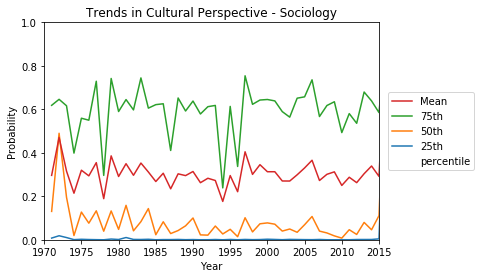

In [84]:
ax = sns.lineplot(x="year_int", y="prediction_cult", data=df_pct_soc, hue = 'percentile')
ax.set(xlabel='Year', ylabel='Probability')
ax.set(xlim=(1970, 2015))
ax.set(ylim=(0.0, 1.0))

ax.set_title('Trends in Cultural Perspective - Sociology')

ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)

fig.set_size_inches(8, 6)
title = f"cult_soc_trends_{str(thisday)}_MLP_unphrased"
plt.savefig("../figures/" + title + ".png", dpi=200, figsize=(8, 6), bbox_inches="tight")
plt.show()

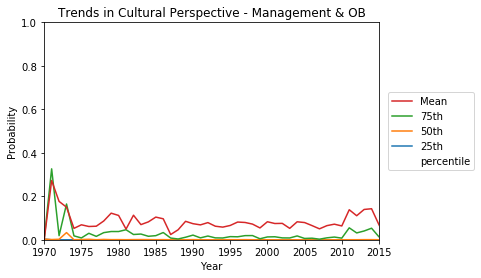

In [94]:
ax = sns.lineplot(x="year_int", y="prediction_cult", data=df_pct_mgt, hue = 'percentile')
ax.set(xlabel='Year', ylabel='Probability')
ax.set(xlim=(1970, 2015))
ax.set(ylim=(0.0, 1.0))

ax.set_title('Trends in Cultural Perspective - Management & OB')

ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)

fig.set_size_inches(8, 6)
title = f"cult_mgt_trends_{str(thisday)}_MLP_unphrased"
plt.savefig("../figures/" + title + ".png", dpi=200, figsize=(8, 6), bbox_inches="tight")
plt.show()

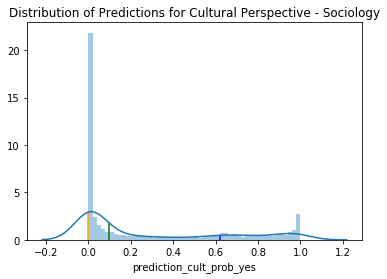

Skew of Distribution
0.8659689714492935


In [86]:
ax = sns.distplot(df_orgsoc["prediction_cult_prob_yes"], bins = 50)
# ax.set(xlabel='Year', ylabel='Avg. Engagement')

ax.set_title('Distribution of Predictions for Cultural Perspective - Sociology')

x,y = ax.get_lines()[0].get_data()
cdf = integrate.cumtrapz(y, x, initial=0)

nearest_05 = np.abs(cdf-0.5).argmin()
nearest_025 = np.abs(cdf-0.25).argmin()
nearest_075 = np.abs(cdf-0.75).argmin()


x_median = x[nearest_05]
y_median = y[nearest_05]

x_025 = x[nearest_025]
y_025 = y[nearest_025]

x_075 = x[nearest_075]
y_075 = y[nearest_075]

plt.vlines(x_median, 0, y_median, color = 'green')
plt.vlines(x_025, 0, y_025, color = 'orange')
plt.vlines(x_075, 0, y_075, color = 'blue')

plt.show()
print("Skew of Distribution") 
print(df_orgsoc["prediction_cult_prob_yes"].skew())

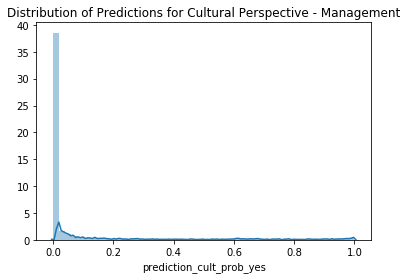

Skew of Distribution
2.8966341480088644


In [87]:
ax = sns.distplot(df[df['primary_subject'] == 'Management & Organizational Behavior']["prediction_cult_prob_yes"], bins = 50)
# ax.set(xlabel='Year', ylabel='Avg. Engagement')
# ax.set(xlim=(0, 0.5))
ax.set_title('Distribution of Predictions for Cultural Perspective - Management')

x,y = ax.get_lines()[0].get_data()
cdf = integrate.cumtrapz(y, x, initial=0)

nearest_05 = np.abs(cdf-0.5).argmin()
nearest_025 = np.abs(cdf-0.25).argmin()
nearest_075 = np.abs(cdf-0.75).argmin()


x_median = x[nearest_05]
y_median = y[nearest_05]

x_025 = x[nearest_025]
y_025 = y[nearest_025]

x_075 = x[nearest_075]
y_075 = y[nearest_075]

plt.vlines(x_median, 0, y_median, color = 'green')
plt.vlines(x_025, 0, y_025, color = 'orange')
plt.vlines(x_075, 0, y_075, color = 'blue')

plt.show()
print("Skew of Distribution") 
print(df[df['primary_subject'] == 'Management & Organizational Behavior']["prediction_cult_prob_yes"].skew())

#### Relational

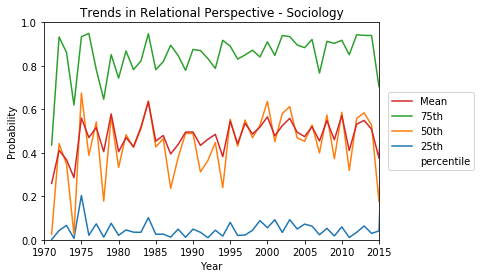

In [88]:
ax = sns.lineplot(x="year_int", y="prediction_relt", data=df_pct_soc, hue = 'percentile')
ax.set(xlabel='Year', ylabel='Probability')
ax.set(xlim=(1970, 2015))
ax.set(ylim=(0.0, 1.0))

ax.set_title('Trends in Relational Perspective - Sociology')

ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)

fig.set_size_inches(8, 6)
title = f"relt_soc_trends_{str(thisday)}_MLP_unphrased"
plt.savefig("../figures/" + title + ".png", dpi=200, figsize=(8, 6), bbox_inches="tight")
plt.show()

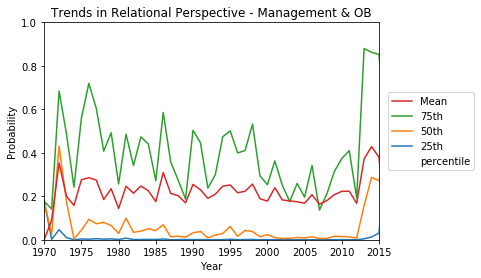

In [93]:
ax = sns.lineplot(x="year_int", y="prediction_relt", data=df_pct_mgt, hue = 'percentile')
ax.set(xlabel='Year', ylabel='Probability')
ax.set(xlim=(1970, 2015))
ax.set(ylim=(0.0, 1.0))

ax.set_title('Trends in Relational Perspective - Management & OB')

ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)

fig.set_size_inches(8, 6)
title = f"relt_mgt_trends_{str(thisday)}_MLP_unphrased"
plt.savefig("../figures/" + title + ".png", dpi=200, figsize=(8, 6), bbox_inches="tight")
plt.show()

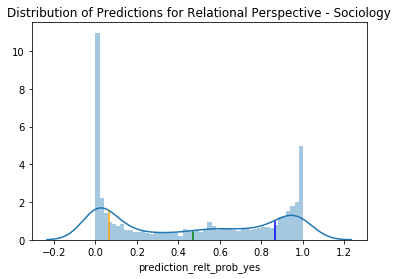

Skew of Distribution
0.8659689714492935


In [90]:
ax = sns.distplot(df_orgsoc["prediction_relt_prob_yes"], bins = 50)
# ax.set(xlabel='Year', ylabel='Avg. Engagement')
# ax.set(xlim=(0, 0.5))

ax.set_title('Distribution of Predictions for Relational Perspective - Sociology')

x,y = ax.get_lines()[0].get_data()
cdf = integrate.cumtrapz(y, x, initial=0)

nearest_05 = np.abs(cdf-0.5).argmin()
nearest_025 = np.abs(cdf-0.25).argmin()
nearest_075 = np.abs(cdf-0.75).argmin()


x_median = x[nearest_05]
y_median = y[nearest_05]

x_025 = x[nearest_025]
y_025 = y[nearest_025]

x_075 = x[nearest_075]
y_075 = y[nearest_075]

plt.vlines(x_median, 0, y_median, color = 'green')
plt.vlines(x_025, 0, y_025, color = 'orange')
plt.vlines(x_075, 0, y_075, color = 'blue')

plt.show()
print("Skew of Distribution") 
print(df_orgsoc["prediction_cult_prob_yes"].skew())

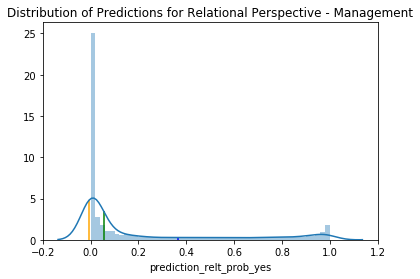

Skew of Distribution
2.8966341480088644


In [91]:
ax = sns.distplot(df[df['primary_subject'] == 'Management & Organizational Behavior']["prediction_relt_prob_yes"], bins = 50)
# ax.set(xlabel='Year', ylabel='Avg. Engagement')
# ax.set(xlim=(0, 0.5))
ax.set_title('Distribution of Predictions for Relational Perspective - Management')

x,y = ax.get_lines()[0].get_data()
cdf = integrate.cumtrapz(y, x, initial=0)

nearest_05 = np.abs(cdf-0.5).argmin()
nearest_025 = np.abs(cdf-0.25).argmin()
nearest_075 = np.abs(cdf-0.75).argmin()


x_median = x[nearest_05]
y_median = y[nearest_05]

x_025 = x[nearest_025]
y_025 = y[nearest_025]

x_075 = x[nearest_075]
y_075 = y[nearest_075]

plt.vlines(x_median, 0, y_median, color = 'green')
plt.vlines(x_025, 0, y_025, color = 'orange')
plt.vlines(x_075, 0, y_075, color = 'blue')

plt.show()
print("Skew of Distribution") 
print(df[df['primary_subject'] == 'Management & Organizational Behavior']["prediction_cult_prob_yes"].skew())

#### Demographic

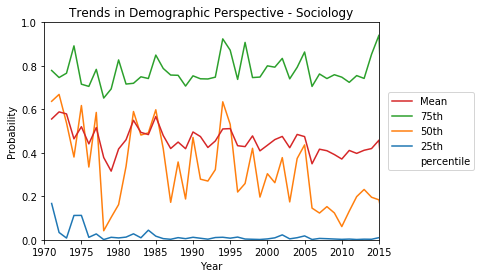

In [92]:
ax = sns.lineplot(x="year_int", y="prediction_demog", data=df_pct_soc, hue = 'percentile')
ax.set(xlabel='Year', ylabel='Probability')
ax.set(xlim=(1970, 2015))
ax.set(ylim=(0.0, 1.0))

ax.set_title('Trends in Demographic Perspective - Sociology')

ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)

fig.set_size_inches(8, 6)
title = f"demog_soc_trends_{str(thisday)}_MLP_unphrased"
plt.savefig("../figures/" + title + ".png", dpi=200, figsize=(8, 6), bbox_inches="tight")
plt.show()

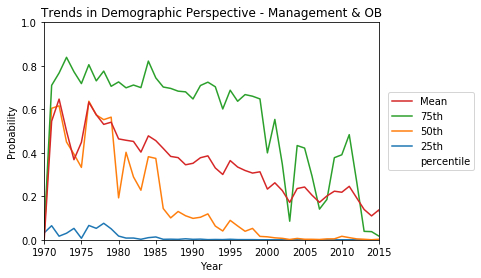

In [95]:
ax = sns.lineplot(x="year_int", y="prediction_demog", data=df_pct_mgt, hue = 'percentile')
ax.set(xlabel='Year', ylabel='Probability')
ax.set(xlim=(1970, 2015))
ax.set(ylim=(0.0, 1.0))

ax.set_title('Trends in Demographic Perspective - Management & OB')

ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)

fig.set_size_inches(8, 6)
title = f"demog_mgt_trends_{str(thisday)}_MLP_unphrased"
plt.savefig("../figures/" + title + ".png", dpi=200, figsize=(8, 6), bbox_inches="tight")
plt.show()

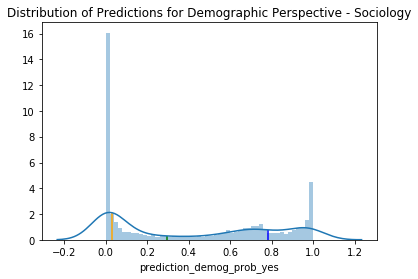

Skew of Distribution
0.8659689714492935


In [96]:
ax = sns.distplot(df_orgsoc["prediction_demog_prob_yes"], bins = 50)
# ax.set(xlabel='Year', ylabel='Avg. Engagement')
# ax.set(xlim=(0, 0.5))

ax.set_title('Distribution of Predictions for Demographic Perspective - Sociology')

x,y = ax.get_lines()[0].get_data()
cdf = integrate.cumtrapz(y, x, initial=0)

nearest_05 = np.abs(cdf-0.5).argmin()
nearest_025 = np.abs(cdf-0.25).argmin()
nearest_075 = np.abs(cdf-0.75).argmin()


x_median = x[nearest_05]
y_median = y[nearest_05]

x_025 = x[nearest_025]
y_025 = y[nearest_025]

x_075 = x[nearest_075]
y_075 = y[nearest_075]

plt.vlines(x_median, 0, y_median, color = 'green')
plt.vlines(x_025, 0, y_025, color = 'orange')
plt.vlines(x_075, 0, y_075, color = 'blue')

plt.show()
print("Skew of Distribution") 
print(df_orgsoc["prediction_cult_prob_yes"].skew())

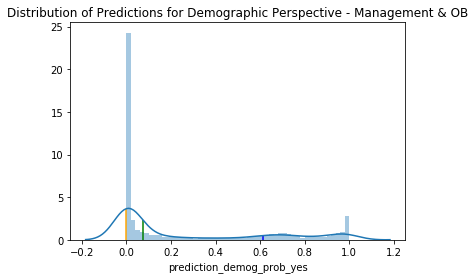

Skew of Distribution
2.8966341480088644


In [97]:
ax = sns.distplot(df[df['primary_subject'] == 'Management & Organizational Behavior']["prediction_demog_prob_yes"], bins = 50)
# ax.set(xlabel='Year', ylabel='Avg. Engagement')
# ax.set(xlim=(0, 0.5))
ax.set_title('Distribution of Predictions for Demographic Perspective - Management & OB')

x,y = ax.get_lines()[0].get_data()
cdf = integrate.cumtrapz(y, x, initial=0)

nearest_05 = np.abs(cdf-0.5).argmin()
nearest_025 = np.abs(cdf-0.25).argmin()
nearest_075 = np.abs(cdf-0.75).argmin()


x_median = x[nearest_05]
y_median = y[nearest_05]

x_025 = x[nearest_025]
y_025 = y[nearest_025]

x_075 = x[nearest_075]
y_075 = y[nearest_075]

plt.vlines(x_median, 0, y_median, color = 'green')
plt.vlines(x_025, 0, y_025, color = 'orange')
plt.vlines(x_075, 0, y_075, color = 'blue')

plt.show()
print("Skew of Distribution") 
print(df[df['primary_subject'] == 'Management & Organizational Behavior']["prediction_cult_prob_yes"].skew())